In [ ]:
import os
import tarfile
import requests
from scipy.io import loadmat
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm # For progress bars


DATA_DIR = 'flowers_data_resnet152' # New directory for this enhanced dataset
IMAGE_DIR_ORIGINAL = os.path.join(DATA_DIR, 'jpg') # Original images
MASK_DIR = os.path.join(DATA_DIR, 'segmim') # Directory where segmentation masks will be extracted
NUM_CLASSES = 102
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS_HEAD = 30 # Epochs for training only the classifier head
NUM_EPOCHS_FINETUNE = 30 # Epochs for fine-tuning the entire model (or parts of it)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)


def download_and_extract_all():
    files_to_download = {
        '102flowers.tgz': {
            'url': 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz',
            'extract_path': DATA_DIR,
            'check_extracted': IMAGE_DIR_ORIGINAL
        },
        'imagelabels.mat': {
            'url': 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat',
            'extract_path': None, # No extraction needed
            'check_extracted': None
        },
        'setid.mat': {
            'url': 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat',
            'extract_path': None, # No extraction needed
            'check_extracted': None
        },
        '102segmentations.tgz': {
            'url': 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz',
            'extract_path': DATA_DIR, # Should extract into its own folder e.g. 'segmim'
            'check_extracted': MASK_DIR
        }
    }

    for filename, info in files_to_download.items():
        filepath = os.path.join(DATA_DIR, filename)
        extracted_path_exists = False
        if info['check_extracted']:
            extracted_path_exists = os.path.exists(info['check_extracted'])


        if not os.path.exists(filepath) and not extracted_path_exists:
            print(f"Downloading {filename}...")
            try:
                r = requests.get(info['url'], stream=True)
                r.raise_for_status() # Check for HTTP errors
                with open(filepath, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192*4): # Increased chunk size
                        f.write(chunk)
                print(f"Downloaded {filename}.")
            except requests.exceptions.RequestException as e:
                print(f"Error downloading {filename}: {e}")
                continue # Skip to next file if download fails

        if filename.endswith('.tgz') and not extracted_path_exists:
            if os.path.exists(filepath): # Check if file was downloaded
                print(f"Extracting {filename}...")
                try:
                    with tarfile.open(filepath, 'r:gz') as tar:
                        tar.extractall(path=info['extract_path'])
                    print(f"Extracted {filename}.")
                    # Special check for mask directory name, VGG datasets often put it in 'segmim'
                    if filename == '102segmentations.tgz' and not os.path.exists(MASK_DIR):
                        extracted_folders = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
                        for folder in extracted_folders:
                            if 'seg' in folder.lower(): # Heuristic
                                try:
                                    os.rename(os.path.join(DATA_DIR, folder), MASK_DIR)
                                    print(f"Renamed extracted segmentation folder to {MASK_DIR}")
                                    break
                                except OSError as e:
                                    print(f"Could not rename segmentation folder: {e}. Please check extraction for {filename}.")
                        if not os.path.exists(MASK_DIR):
                             print(f"Warning: Expected mask directory {MASK_DIR} not found after extraction of {filename}.")

                except tarfile.TarError as e:
                    print(f"Error extracting {filename}: {e}")
            else:
                print(f"Skipping extraction for {filename} as file does not exist.")

        elif extracted_path_exists:
            print(f"{filename} already downloaded and extracted/present.")
        else:
            print(f"{filename} already downloaded.")

download_and_extract_all()

# Verify paths after download and extraction
print(f"Checking existence of {IMAGE_DIR_ORIGINAL}: {os.path.exists(IMAGE_DIR_ORIGINAL)}")
print(f"Checking existence of {MASK_DIR}: {os.path.exists(MASK_DIR)}")
print(f"Checking existence of {os.path.join(DATA_DIR, 'imagelabels.mat')}: {os.path.exists(os.path.join(DATA_DIR, 'imagelabels.mat'))}")
print(f"Checking existence of {os.path.join(DATA_DIR, 'setid.mat')}: {os.path.exists(os.path.join(DATA_DIR, 'setid.mat'))}")

Using device: cuda
102flowers.tgz already downloaded and extracted/present.
imagelabels.mat already downloaded.
setid.mat already downloaded.
102segmentations.tgz already downloaded and extracted/present.
Checking existence of flowers_data_resnet152\jpg: True
Checking existence of flowers_data_resnet152\segmim: True
Checking existence of flowers_data_resnet152\imagelabels.mat: True
Checking existence of flowers_data_resnet152\setid.mat: True


In [ ]:
from PIL import Image, ImageOps
import torchvision.transforms.functional as TF

class FlowersDatasetWithMasks(Dataset):
    def __init__(self, image_dir, mask_dir, labels_file, setid_file, split='train', transform=None, mask_threshold=10):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.labels_data = loadmat(labels_file)['labels'][0] - 1 # Labels 0-indexed
        setid_data = loadmat(setid_file)

        if split == 'train':
            # For training, use the 'trnid' (1020 images) and 'valid' (1020 images) combined
            # as often done to get a larger training set, then split validation later if needed
            # or use 'valid' strictly for validation during training.
            # For this example, we'll stick to the provided splits first.
            # If results are poor due to small train set, combining trnid and valid is an option.
            self.image_indices = setid_data['trnid'][0] - 1
        elif split == 'val':
            self.image_indices = setid_data['valid'][0] - 1
        elif split == 'test':
            self.image_indices = setid_data['tstid'][0] - 1
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")


        self.image_filenames = [f"image_{i+1:05d}.jpg" for i in self.image_indices]
        self.mask_filenames = [f"image_{i+1:05d}.png" for i in self.image_indices] # Assuming mask names match
        self.image_labels = [self.labels_data[i] for i in self.image_indices]
        self.mask_threshold = mask_threshold # Pixel value threshold to binarize the mask

        # Check if mask directory and files actually exist
        if not os.path.exists(self.mask_dir):
            print(f"WARNING: Mask directory {self.mask_dir} does not exist!")
            self.mask_dir = None # Disable mask loading if dir not found
        elif self.mask_dir and len(self.image_indices) > 0:
            # Check for the first mask file to be more robust
            first_mask_path = os.path.join(self.mask_dir, self.mask_filenames[0])
            if not os.path.exists(first_mask_path):
                print(f"WARNING: First mask file {first_mask_path} not found in {self.mask_dir}!")
                # This could indicate a wrong mask_dir or naming convention issue.
                # For now, we'll proceed without masks if the first one is missing,
                # but ideally, this should be a hard error or a more sophisticated check.
                # self.mask_dir = None # Or raise an error

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')

        mask = None
        if self.mask_dir:
            mask_name = os.path.join(self.mask_dir, self.mask_filenames[idx])
            if os.path.exists(mask_name):
                try:
                    # Segmentation masks are usually L (luminance/grayscale)
                    mask = Image.open(mask_name).convert('L')
                except FileNotFoundError:
                    # This shouldn't happen if the directory exists and names are correct, but good to have
                    print(f"Warning: Mask file {mask_name} not found. Proceeding without mask for this image.")
                    mask = None
                except Exception as e:
                    print(f"Warning: Error loading mask {mask_name}: {e}. Proceeding without mask for this image.")
                    mask = None
            else: # If a specific mask file is missing
                # print(f"Warning: Mask file {mask_name} does not exist. Proceeding without mask for this image.")
                mask = None


        # --- Apply mask to image ---
        # Ensure image and mask are the same size before applying transforms
        # This is important if original images and masks have different raw dimensions
        if mask:
            # Resize mask to image size if they are different.
            # Common practice: resize both to target size first THEN apply mask.
            # However, if applying mask before resize, sizes must match.
            # Let's assume transforms will handle resizing of the combined image.
            # If image is (H, W) and mask is (H', W'), make them match.
            # Simplest: resize mask to image's current size if not already.
            if image.size != mask.size:
                mask = mask.resize(image.size, Image.NEAREST) # Use NEAREST for masks

            # Binarize the mask: pixels > threshold are foreground (1), else background (0)
            # The masks from VGG are grayscale. Flower pixels are typically brighter.
            binary_mask_image = mask.point(lambda p: 255 if p > self.mask_threshold else 0, mode='1') # mode '1' for binary
            binary_mask_pil = binary_mask_image.convert('L') # Convert back to L for consistency if needed, or keep as '1'

            img_array = np.array(image)
            mask_array = np.array(binary_mask_pil) # This will be H, W

            # Ensure mask_array is (H, W, 1) or can be broadcast for element-wise multiplication
            # For blackening background:
            img_array[mask_array == 0] = 0 # Set background pixels to black
            image = Image.fromarray(img_array)


        label = self.image_labels[idx]

        # --- Apply Transformations ---
        # Important: If transforms include random cropping, apply them to image and mask CONSISTENTLY if mask were separate.
        # Here, mask is already applied, so we just transform the resulting image.
        if self.transform:
            image = self.transform(image) # Transform the (potentially masked) image

        return image, torch.tensor(label, dtype=torch.long)

Train samples: 1020
Validation samples: 1020
Test samples: 6149
Visualizing a few sample images with masks applied...


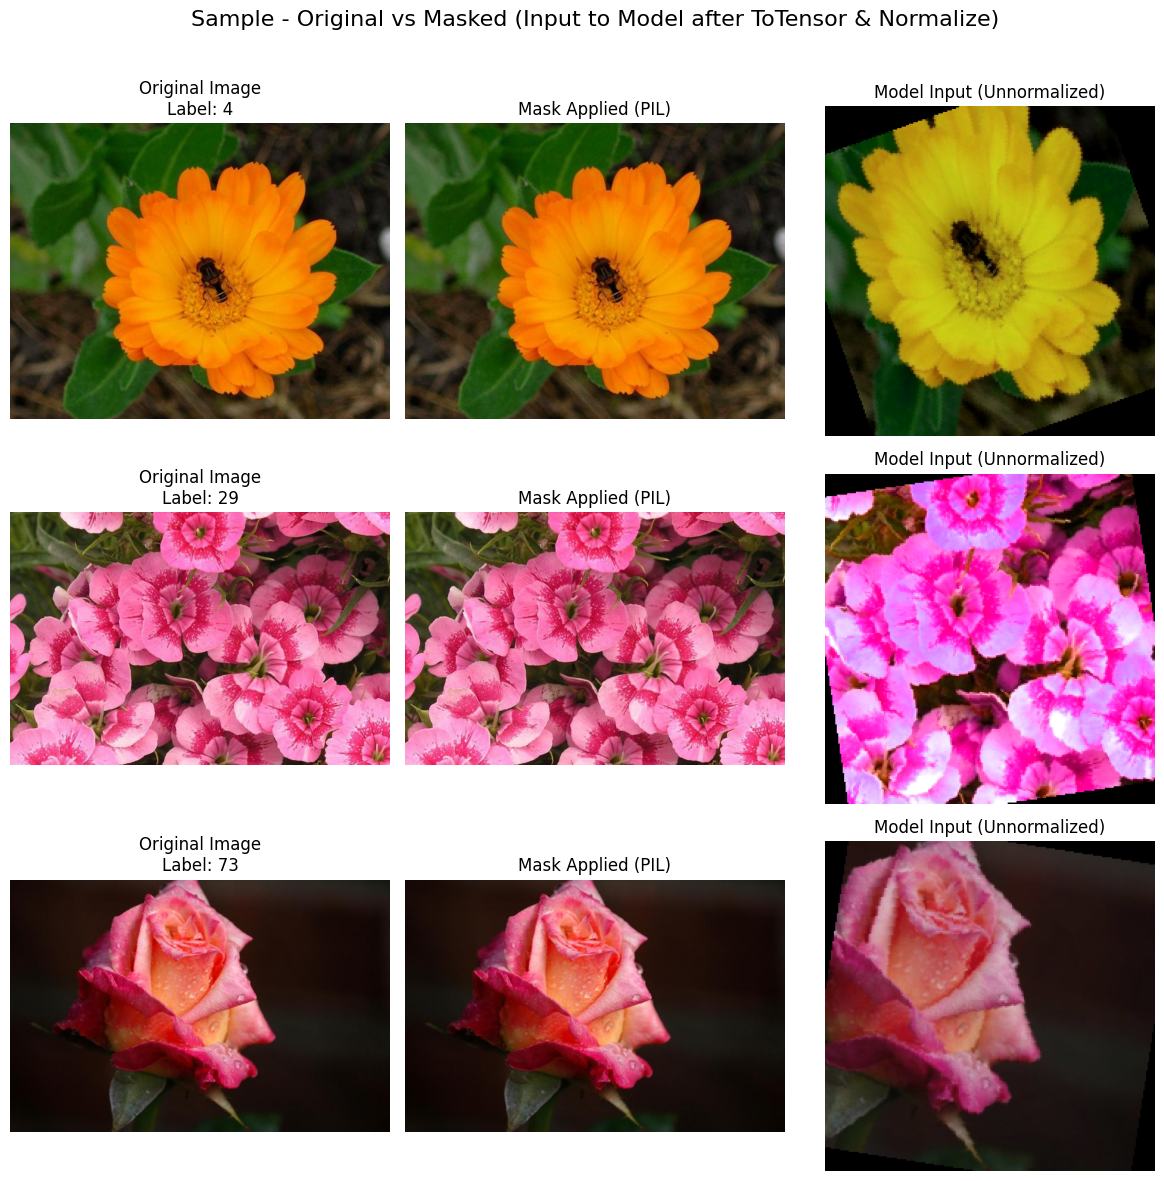

In [ ]:
# --- 3. Data Augmentation and Preprocessing ---
# ResNet50 expects 224x224 images
# Use ImageNet normalization stats
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

# For Training: Apply augmentations to the (masked) image
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)), # Crop a random portion of the image and resize it to 224x224
                                                        # Scale (0.6, 1.0) means crop can be between 60% to 100% of original image area.
                                                        # This helps the model see flowers at different scales and positions.
    transforms.RandomHorizontalFlip(p=0.5),             # Horizontally flip the image with a 50% probability.
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # Randomly change brightness, contrast, etc.
    transforms.RandomRotation(20),                      # Randomly rotate the image by up to 20 degrees.
    transforms.ToTensor(),                              # Convert PIL Image (HWC, 0-255) to PyTorch Tensor (CHW, 0.0-1.0)
    normalize_transform,                                # Normalize tensor with ImageNet mean and std
])

# For Validation and Testing: Only resize, center crop, convert to tensor, and normalize
val_test_transform = transforms.Compose([
    transforms.Resize(256),                             # Resize the smaller edge to 256, maintaining aspect ratio
    transforms.CenterCrop(224),                         # Crop the center 224x224 portion
    transforms.ToTensor(),
    normalize_transform,
])

# --- Instantiate Datasets and DataLoaders ---
labels_path = os.path.join(DATA_DIR, 'imagelabels.mat')
setid_path = os.path.join(DATA_DIR, 'setid.mat')

# Mask threshold can be tuned. Let's start with a reasonable value.
# Inspecting a few masks from the dataset shows that flower pixels are generally bright (often > 50-100),
# while background or undefined areas are darker.
MASK_PIXEL_THRESHOLD = 50 # Example value, might need adjustment

train_dataset = FlowersDatasetWithMasks(
    image_dir=IMAGE_DIR_ORIGINAL,
    mask_dir=MASK_DIR,
    labels_file=labels_path,
    setid_file=setid_path,
    split='train',
    transform=train_transform,
    mask_threshold=MASK_PIXEL_THRESHOLD
)

val_dataset = FlowersDatasetWithMasks(
    image_dir=IMAGE_DIR_ORIGINAL,
    mask_dir=MASK_DIR,
    labels_file=labels_path,
    setid_file=setid_path,
    split='val',
    transform=val_test_transform,
    mask_threshold=MASK_PIXEL_THRESHOLD
)

test_dataset = FlowersDatasetWithMasks(
    image_dir=IMAGE_DIR_ORIGINAL,
    mask_dir=MASK_DIR,
    labels_file=labels_path,
    setid_file=setid_path,
    split='test',
    transform=val_test_transform,
    mask_threshold=MASK_PIXEL_THRESHOLD
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


# --- Visualization (Optional but Highly Recommended) ---
def visualize_sample(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    if num_samples == 1: # Matplotlib handles single subplot differently
        axes = np.array([axes])
    fig.suptitle("Sample - Original vs Masked (Input to Model after ToTensor & Normalize)", fontsize=16)

    for i in range(num_samples):
        

        idx = np.random.randint(0, len(dataset))
        pil_img_original = Image.open(os.path.join(dataset.image_dir, dataset.image_filenames[idx])).convert('RGB')

        pil_mask = None
        if dataset.mask_dir:
            mask_path = os.path.join(dataset.mask_dir, dataset.mask_filenames[idx])
            if os.path.exists(mask_path):
                pil_mask = Image.open(mask_path).convert('L')

        # Re-apply the masking logic here for visualization purposes
        pil_masked_image_display = pil_img_original.copy()
        if pil_mask:
            if pil_masked_image_display.size != pil_mask.size:
                pil_mask_resized = pil_mask.resize(pil_masked_image_display.size, Image.NEAREST)
            else:
                pil_mask_resized = pil_mask
            binary_mask_viz = pil_mask_resized.point(lambda p: 255 if p > dataset.mask_threshold else 0, mode='1')
            
            img_array_viz = np.array(pil_masked_image_display)
            mask_array_viz = np.array(binary_mask_viz.convert('L')) # 0 or 255
            img_array_viz[mask_array_viz == 0] = 0 # Blacken background
            pil_masked_image_display = Image.fromarray(img_array_viz)

        # Get the actual tensor that would go into the model
        # The __getitem__ applies the transform.
        # Note: dataset[idx] returns (transformed_tensor, label)
        transformed_tensor_image, label = dataset[idx]

        # For displaying the transformed tensor, we need to unnormalize it and convert CHW to HWC
        unnormalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], # Inverse of normalization
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_for_display = unnormalize(transformed_tensor_image)
        img_for_display = img_for_display.permute(1, 2, 0) # CHW to HWC for matplotlib
        img_for_display = np.clip(img_for_display.cpu().numpy(), 0, 1) # Clip to valid range

        # Original Image
        axes[i, 0].imshow(pil_img_original)
        axes[i, 0].set_title(f"Original Image\nLabel: {label.item()}")
        axes[i, 0].axis('off')

        # Masked Image (before ToTensor & Normalize, but after binarization and applying mask)
        axes[i, 1].imshow(pil_masked_image_display)
        axes[i, 1].set_title("Mask Applied (PIL)")
        axes[i, 1].axis('off')
        
        # What Model Sees (after all transforms including ToTensor and Normalize)
        axes[i, 2].imshow(img_for_display)
        axes[i, 2].set_title("Model Input (Unnormalized)")
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

if MASK_DIR and os.path.exists(MASK_DIR): 
    print("Visualizing a few sample images with masks applied...")
    visualize_sample(train_dataset, num_samples=3)
else:
    print("Skipping visualization as mask directory is not available.")

In [ ]:


# --- 4. Load Pre-trained ResNet50 and Modify Classifier ---

# Load ResNet50 with ImageNet weights
# Using ResNet50_Weights.IMAGENET1K_V2 for newer, potentially better weights.
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) # Preferred if available


print("Freezing parameters of the pre-trained ResNet base...")
for param in model.parameters():
    param.requires_grad = False
print("Parameters frozen.")


num_ftrs = model.fc.in_features
print(f"Number of input features to the original fc layer: {num_ftrs}") # Should be 2048 for ResNet50


model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
print(f"Replaced fc layer with new nn.Linear({num_ftrs}, {NUM_CLASSES})")

# Move the model to the specified device (GPU if available, else CPU)
model = model.to(DEVICE)
print(f"Model moved to {DEVICE}.")

# --- Verify which parameters are trainable ---
print("\nTrainable parameters after replacing the head:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name} (shape: {param.shape})")




criterion = nn.CrossEntropyLoss()
print(f"\nLoss function: CrossEntropyLoss")


optimizer_head = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=0.01 # A common default for weight decay
)
print(f"Optimizer for classifier head: AdamW with LR={LEARNING_RATE}")

scheduler_head = optim.lr_scheduler.CosineAnnealingLR(optimizer_head, T_max=NUM_EPOCHS_HEAD, eta_min=LEARNING_RATE/100)

print(f"Learning rate scheduler: CosineAnnealingLR with T_max={NUM_EPOCHS_HEAD}")

Freezing parameters of the pre-trained ResNet base...
Parameters frozen.
Number of input features to the original fc layer: 2048
Replaced fc layer with new nn.Linear(2048, 102)
Model moved to cuda.

Trainable parameters after replacing the head:
  fc.weight (shape: torch.Size([102, 2048]))
  fc.bias (shape: torch.Size([102]))

Loss function: CrossEntropyLoss
Optimizer for classifier head: AdamW with LR=0.001
Learning rate scheduler: CosineAnnealingLR with T_max=30


In [ ]:

import time
import copy

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# --- Training Function for one epoch ---
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch_num, total_epochs):
    model.train()  # Set model to training mode (enables dropout, batch norm updates, etc.)

    losses = AverageMeter()
    accuracies = AverageMeter()

    # Using tqdm for a progress bar
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch_num+1}/{total_epochs} [Train]", unit="batch")

    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels.data).item() / labels.size(0)

        # Record loss and accuracy
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        # Update progress bar
        progress_bar.set_postfix(loss=losses.avg, acc=accuracies.avg, lr=optimizer.param_groups[0]['lr'])

    return losses.avg, accuracies.avg

# --- Validation Function for one epoch ---
def validate_one_epoch(model, criterion, data_loader, device, epoch_num, total_epochs):
    model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batch norm)

    losses = AverageMeter()
    accuracies = AverageMeter()

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch_num+1}/{total_epochs} [Val]", unit="batch")

    with torch.no_grad():  # No need to track gradients during validation
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == labels.data).item() / labels.size(0)

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            progress_bar.set_postfix(loss=losses.avg, acc=accuracies.avg)

    return losses.avg, accuracies.avg

# --- Main Training Loop ---
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs, model_name_prefix="best_model"):
    best_val_accuracy = 0.0
    best_model_wts = None # To store weights of the best model
    best_epoch = -1

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    print(f"\n--- Starting Training ({model_name_prefix}) ---")
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Train for one epoch
        train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, num_epochs)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])


        # Validate the model
        val_loss, val_acc = validate_one_epoch(model, criterion, val_loader, device, epoch, num_epochs)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | Time: {epoch_time:.2f}s")

        # Step the scheduler
        if scheduler:
            # For ReduceLROnPlateau, step with validation loss
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else: # For others like CosineAnnealingLR, StepLR
                scheduler.step()

        # Save the model if validation accuracy has improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict()) # Deepcopy is important!
            best_epoch = epoch + 1
            model_save_path = os.path.join(DATA_DIR, f"{model_name_prefix}_epoch{best_epoch}_acc{best_val_accuracy:.4f}.pth")
            torch.save(best_model_wts, model_save_path)
            print(f"🎉 New best model saved with Val Acc: {best_val_accuracy:.4f} at epoch {best_epoch} to {model_save_path}")

    total_training_time = time.time() - start_time
    print(f"\n--- Training Finished ({model_name_prefix}) ---")
    print(f"Total training time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
    if best_model_wts:
        print(f"Best Validation Accuracy: {best_val_accuracy:.4f} achieved at epoch {best_epoch}")
        # Load best model weights back into model object for final use/testing
        model.load_state_dict(best_model_wts)
    else:
        print("No improvement in validation accuracy recorded. Final model is from the last epoch.")

    return model, history


# --- Execute Training for the Classifier Head ---
print("\nPhase 1: Training the classifier head...")


model_head_trained, history_head = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer_head,
    scheduler=scheduler_head, 
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    num_epochs=NUM_EPOCHS_HEAD,
    model_name_prefix="resnet50_flowers_head"
)


Phase 1: Training the classifier head...

--- Starting Training (resnet50_flowers_head) ---


Epoch 1/30 [Val]: 100%|██████████| 32/32 [00:13<00:00,  2.43batch/s, acc=0.602, loss=3.37]


Epoch 1/30 - Train Loss: 3.6296 Acc: 0.5696 | Val Loss: 3.3712 Acc: 0.6020 | Time: 30.80s
🎉 New best model saved with Val Acc: 0.6020 at epoch 1 to flowers_data_resnet152\resnet50_flowers_head_epoch1_acc0.6020.pth


Epoch 2/30 [Val]: 100%|██████████| 32/32 [00:16<00:00,  1.98batch/s, acc=0.673, loss=2.88]


Epoch 2/30 - Train Loss: 2.9555 Acc: 0.7951 | Val Loss: 2.8782 Acc: 0.6725 | Time: 36.26s
🎉 New best model saved with Val Acc: 0.6725 at epoch 2 to flowers_data_resnet152\resnet50_flowers_head_epoch2_acc0.6725.pth


Epoch 3/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, acc=0.73, loss=2.48] 


Epoch 3/30 - Train Loss: 2.4141 Acc: 0.8402 | Val Loss: 2.4820 Acc: 0.7304 | Time: 28.45s
🎉 New best model saved with Val Acc: 0.7304 at epoch 3 to flowers_data_resnet152\resnet50_flowers_head_epoch3_acc0.7304.pth


Epoch 4/30 [Val]: 100%|██████████| 32/32 [00:17<00:00,  1.80batch/s, acc=0.742, loss=2.2] 


Epoch 4/30 - Train Loss: 2.0158 Acc: 0.8922 | Val Loss: 2.1969 Acc: 0.7422 | Time: 38.70s
🎉 New best model saved with Val Acc: 0.7422 at epoch 4 to flowers_data_resnet152\resnet50_flowers_head_epoch4_acc0.7422.pth


Epoch 5/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, acc=0.762, loss=1.99]


Epoch 5/30 - Train Loss: 1.6625 Acc: 0.9049 | Val Loss: 1.9873 Acc: 0.7618 | Time: 28.29s
🎉 New best model saved with Val Acc: 0.7618 at epoch 5 to flowers_data_resnet152\resnet50_flowers_head_epoch5_acc0.7618.pth


Epoch 6/30 [Val]: 100%|██████████| 32/32 [00:16<00:00,  1.90batch/s, acc=0.787, loss=1.78]


Epoch 6/30 - Train Loss: 1.4093 Acc: 0.9422 | Val Loss: 1.7843 Acc: 0.7873 | Time: 38.40s
🎉 New best model saved with Val Acc: 0.7873 at epoch 6 to flowers_data_resnet152\resnet50_flowers_head_epoch6_acc0.7873.pth


Epoch 7/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.59batch/s, acc=0.79, loss=1.64] 


Epoch 7/30 - Train Loss: 1.2225 Acc: 0.9422 | Val Loss: 1.6352 Acc: 0.7902 | Time: 29.17s
🎉 New best model saved with Val Acc: 0.7902 at epoch 7 to flowers_data_resnet152\resnet50_flowers_head_epoch7_acc0.7902.pth


Epoch 8/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.07batch/s, acc=0.793, loss=1.56]


Epoch 8/30 - Train Loss: 1.0872 Acc: 0.9559 | Val Loss: 1.5606 Acc: 0.7931 | Time: 36.31s
🎉 New best model saved with Val Acc: 0.7931 at epoch 8 to flowers_data_resnet152\resnet50_flowers_head_epoch8_acc0.7931.pth


Epoch 9/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.78batch/s, acc=0.798, loss=1.48]


Epoch 9/30 - Train Loss: 0.9573 Acc: 0.9618 | Val Loss: 1.4775 Acc: 0.7980 | Time: 24.45s
🎉 New best model saved with Val Acc: 0.7980 at epoch 9 to flowers_data_resnet152\resnet50_flowers_head_epoch9_acc0.7980.pth


Epoch 10/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.03batch/s, acc=0.804, loss=1.38]


Epoch 10/30 - Train Loss: 0.8665 Acc: 0.9676 | Val Loss: 1.3819 Acc: 0.8039 | Time: 33.76s
🎉 New best model saved with Val Acc: 0.8039 at epoch 10 to flowers_data_resnet152\resnet50_flowers_head_epoch10_acc0.8039.pth


Epoch 11/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.74batch/s, acc=0.809, loss=1.32]


Epoch 11/30 - Train Loss: 0.8040 Acc: 0.9637 | Val Loss: 1.3183 Acc: 0.8088 | Time: 24.66s
🎉 New best model saved with Val Acc: 0.8088 at epoch 11 to flowers_data_resnet152\resnet50_flowers_head_epoch11_acc0.8088.pth


Epoch 12/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.05batch/s, acc=0.81, loss=1.29] 


Epoch 12/30 - Train Loss: 0.7498 Acc: 0.9657 | Val Loss: 1.2863 Acc: 0.8098 | Time: 33.64s
🎉 New best model saved with Val Acc: 0.8098 at epoch 12 to flowers_data_resnet152\resnet50_flowers_head_epoch12_acc0.8098.pth


Epoch 13/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.66batch/s, acc=0.817, loss=1.23]


Epoch 13/30 - Train Loss: 0.6798 Acc: 0.9725 | Val Loss: 1.2294 Acc: 0.8167 | Time: 25.06s
🎉 New best model saved with Val Acc: 0.8167 at epoch 13 to flowers_data_resnet152\resnet50_flowers_head_epoch13_acc0.8167.pth


Epoch 14/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.04batch/s, acc=0.82, loss=1.2]  


Epoch 14/30 - Train Loss: 0.6433 Acc: 0.9755 | Val Loss: 1.2007 Acc: 0.8196 | Time: 34.00s
🎉 New best model saved with Val Acc: 0.8196 at epoch 14 to flowers_data_resnet152\resnet50_flowers_head_epoch14_acc0.8196.pth


Epoch 15/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.77batch/s, acc=0.815, loss=1.16]


Epoch 15/30 - Train Loss: 0.6101 Acc: 0.9755 | Val Loss: 1.1638 Acc: 0.8147 | Time: 24.43s


Epoch 16/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.76batch/s, acc=0.817, loss=1.14]


Epoch 16/30 - Train Loss: 0.5389 Acc: 0.9833 | Val Loss: 1.1352 Acc: 0.8167 | Time: 24.68s


Epoch 17/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.74batch/s, acc=0.818, loss=1.11]


Epoch 17/30 - Train Loss: 0.5271 Acc: 0.9814 | Val Loss: 1.1073 Acc: 0.8176 | Time: 24.88s


Epoch 18/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, acc=0.821, loss=1.13]


Epoch 18/30 - Train Loss: 0.5301 Acc: 0.9784 | Val Loss: 1.1338 Acc: 0.8206 | Time: 25.26s
🎉 New best model saved with Val Acc: 0.8206 at epoch 18 to flowers_data_resnet152\resnet50_flowers_head_epoch18_acc0.8206.pth


Epoch 19/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.03batch/s, acc=0.824, loss=1.1] 


Epoch 19/30 - Train Loss: 0.5129 Acc: 0.9755 | Val Loss: 1.1015 Acc: 0.8235 | Time: 34.02s
🎉 New best model saved with Val Acc: 0.8235 at epoch 19 to flowers_data_resnet152\resnet50_flowers_head_epoch19_acc0.8235.pth


Epoch 20/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.69batch/s, acc=0.822, loss=1.08]


Epoch 20/30 - Train Loss: 0.4897 Acc: 0.9853 | Val Loss: 1.0773 Acc: 0.8216 | Time: 25.09s


Epoch 21/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.74batch/s, acc=0.822, loss=1.08]


Epoch 21/30 - Train Loss: 0.4840 Acc: 0.9814 | Val Loss: 1.0775 Acc: 0.8216 | Time: 24.56s


Epoch 22/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.78batch/s, acc=0.822, loss=1.06]


Epoch 22/30 - Train Loss: 0.4724 Acc: 0.9794 | Val Loss: 1.0556 Acc: 0.8216 | Time: 24.49s


Epoch 23/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.73batch/s, acc=0.825, loss=1.03] 


Epoch 23/30 - Train Loss: 0.4433 Acc: 0.9853 | Val Loss: 1.0345 Acc: 0.8245 | Time: 24.93s
🎉 New best model saved with Val Acc: 0.8245 at epoch 23 to flowers_data_resnet152\resnet50_flowers_head_epoch23_acc0.8245.pth


Epoch 24/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.03batch/s, acc=0.829, loss=1.03] 


Epoch 24/30 - Train Loss: 0.4697 Acc: 0.9853 | Val Loss: 1.0349 Acc: 0.8294 | Time: 33.87s
🎉 New best model saved with Val Acc: 0.8294 at epoch 24 to flowers_data_resnet152\resnet50_flowers_head_epoch24_acc0.8294.pth


Epoch 25/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.74batch/s, acc=0.831, loss=1.02] 


Epoch 25/30 - Train Loss: 0.4548 Acc: 0.9814 | Val Loss: 1.0243 Acc: 0.8314 | Time: 24.68s
🎉 New best model saved with Val Acc: 0.8314 at epoch 25 to flowers_data_resnet152\resnet50_flowers_head_epoch25_acc0.8314.pth


Epoch 26/30 [Val]: 100%|██████████| 32/32 [00:15<00:00,  2.01batch/s, acc=0.832, loss=1.03] 


Epoch 26/30 - Train Loss: 0.4423 Acc: 0.9902 | Val Loss: 1.0311 Acc: 0.8324 | Time: 33.87s
🎉 New best model saved with Val Acc: 0.8324 at epoch 26 to flowers_data_resnet152\resnet50_flowers_head_epoch26_acc0.8324.pth


Epoch 27/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.75batch/s, acc=0.828, loss=1.03] 


Epoch 27/30 - Train Loss: 0.4380 Acc: 0.9912 | Val Loss: 1.0270 Acc: 0.8284 | Time: 24.83s


Epoch 28/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.77batch/s, acc=0.827, loss=1.03] 


Epoch 28/30 - Train Loss: 0.4351 Acc: 0.9833 | Val Loss: 1.0317 Acc: 0.8275 | Time: 24.93s


Epoch 29/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.56batch/s, acc=0.824, loss=1.03] 


Epoch 29/30 - Train Loss: 0.4343 Acc: 0.9853 | Val Loss: 1.0272 Acc: 0.8235 | Time: 25.52s


Epoch 30/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.75batch/s, acc=0.825, loss=1.03] 

Epoch 30/30 - Train Loss: 0.4390 Acc: 0.9902 | Val Loss: 1.0291 Acc: 0.8245 | Time: 25.73s

--- Training Finished (resnet50_flowers_head) ---
Total training time: 14m 30s
Best Validation Accuracy: 0.8324 achieved at epoch 26



--- Starting Phase 2: Fine-tuning the model ---
Unfreezing all model parameters for fine-tuning...
All parameters unfrozen.
Optimizer for fine-tuning: AdamW with LR=0.0001
Learning rate scheduler for fine-tuning: CosineAnnealingLR with T_max=30

--- Starting Training (resnet50_flowers_finetuned) ---


Epoch 1/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.55batch/s, acc=0.866, loss=0.534]


Epoch 1/30 - Train Loss: 0.1354 Acc: 0.9755 | Val Loss: 0.5341 Acc: 0.8657 | Time: 51.39s
🎉 New best model saved with Val Acc: 0.8657 at epoch 1 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch1_acc0.8657.pth


Epoch 2/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.57batch/s, acc=0.873, loss=0.484]


Epoch 2/30 - Train Loss: 0.0536 Acc: 0.9951 | Val Loss: 0.4835 Acc: 0.8725 | Time: 49.59s
🎉 New best model saved with Val Acc: 0.8725 at epoch 2 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch2_acc0.8725.pth


Epoch 3/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.76batch/s, acc=0.875, loss=0.459]


Epoch 3/30 - Train Loss: 0.0332 Acc: 0.9941 | Val Loss: 0.4590 Acc: 0.8755 | Time: 47.98s
🎉 New best model saved with Val Acc: 0.8755 at epoch 3 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch3_acc0.8755.pth


Epoch 4/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.73batch/s, acc=0.878, loss=0.432]


Epoch 4/30 - Train Loss: 0.0209 Acc: 0.9990 | Val Loss: 0.4324 Acc: 0.8784 | Time: 46.26s
🎉 New best model saved with Val Acc: 0.8784 at epoch 4 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch4_acc0.8784.pth


Epoch 5/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68batch/s, acc=0.888, loss=0.422]


Epoch 5/30 - Train Loss: 0.0192 Acc: 0.9990 | Val Loss: 0.4217 Acc: 0.8882 | Time: 46.23s
🎉 New best model saved with Val Acc: 0.8882 at epoch 5 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch5_acc0.8882.pth


Epoch 6/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.63batch/s, acc=0.881, loss=0.43] 


Epoch 6/30 - Train Loss: 0.0136 Acc: 0.9990 | Val Loss: 0.4302 Acc: 0.8814 | Time: 58.81s


Epoch 7/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.76batch/s, acc=0.883, loss=0.424]


Epoch 7/30 - Train Loss: 0.0141 Acc: 0.9971 | Val Loss: 0.4243 Acc: 0.8833 | Time: 56.82s


Epoch 8/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, acc=0.892, loss=0.401]


Epoch 8/30 - Train Loss: 0.0085 Acc: 0.9990 | Val Loss: 0.4013 Acc: 0.8922 | Time: 58.96s
🎉 New best model saved with Val Acc: 0.8922 at epoch 8 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch8_acc0.8922.pth


Epoch 9/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.73batch/s, acc=0.893, loss=0.388]


Epoch 9/30 - Train Loss: 0.0083 Acc: 0.9990 | Val Loss: 0.3881 Acc: 0.8931 | Time: 46.12s
🎉 New best model saved with Val Acc: 0.8931 at epoch 9 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch9_acc0.8931.pth


Epoch 10/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.70batch/s, acc=0.888, loss=0.405]


Epoch 10/30 - Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.4051 Acc: 0.8882 | Time: 58.13s


Epoch 11/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, acc=0.886, loss=0.395]


Epoch 11/30 - Train Loss: 0.0092 Acc: 0.9980 | Val Loss: 0.3952 Acc: 0.8863 | Time: 60.76s


Epoch 12/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.70batch/s, acc=0.89, loss=0.386] 


Epoch 12/30 - Train Loss: 0.0069 Acc: 0.9990 | Val Loss: 0.3861 Acc: 0.8902 | Time: 58.53s


Epoch 13/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.66batch/s, acc=0.888, loss=0.388]


Epoch 13/30 - Train Loss: 0.0059 Acc: 1.0000 | Val Loss: 0.3876 Acc: 0.8882 | Time: 58.41s


Epoch 14/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.59batch/s, acc=0.896, loss=0.364]


Epoch 14/30 - Train Loss: 0.0037 Acc: 1.0000 | Val Loss: 0.3641 Acc: 0.8961 | Time: 58.72s
🎉 New best model saved with Val Acc: 0.8961 at epoch 14 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch14_acc0.8961.pth


Epoch 15/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.67batch/s, acc=0.896, loss=0.374]


Epoch 15/30 - Train Loss: 0.0022 Acc: 1.0000 | Val Loss: 0.3740 Acc: 0.8961 | Time: 45.87s


Epoch 16/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, acc=0.893, loss=0.362]


Epoch 16/30 - Train Loss: 0.0051 Acc: 1.0000 | Val Loss: 0.3622 Acc: 0.8931 | Time: 46.40s


Epoch 17/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.62batch/s, acc=0.895, loss=0.363]


Epoch 17/30 - Train Loss: 0.0023 Acc: 1.0000 | Val Loss: 0.3628 Acc: 0.8951 | Time: 46.46s


Epoch 18/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.65batch/s, acc=0.896, loss=0.361]


Epoch 18/30 - Train Loss: 0.0027 Acc: 1.0000 | Val Loss: 0.3612 Acc: 0.8961 | Time: 47.08s


Epoch 19/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68batch/s, acc=0.901, loss=0.36] 


Epoch 19/30 - Train Loss: 0.0033 Acc: 1.0000 | Val Loss: 0.3605 Acc: 0.9010 | Time: 46.21s
🎉 New best model saved with Val Acc: 0.9010 at epoch 19 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch19_acc0.9010.pth


Epoch 20/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68batch/s, acc=0.895, loss=0.357]


Epoch 20/30 - Train Loss: 0.0026 Acc: 1.0000 | Val Loss: 0.3570 Acc: 0.8951 | Time: 70.12s


Epoch 21/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.69batch/s, acc=0.9, loss=0.347]  


Epoch 21/30 - Train Loss: 0.0037 Acc: 0.9990 | Val Loss: 0.3473 Acc: 0.9000 | Time: 70.19s


Epoch 22/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.61batch/s, acc=0.896, loss=0.363]


Epoch 22/30 - Train Loss: 0.0033 Acc: 1.0000 | Val Loss: 0.3627 Acc: 0.8961 | Time: 70.54s


Epoch 23/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.67batch/s, acc=0.898, loss=0.356]


Epoch 23/30 - Train Loss: 0.0016 Acc: 1.0000 | Val Loss: 0.3564 Acc: 0.8980 | Time: 70.58s


Epoch 24/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.69batch/s, acc=0.9, loss=0.347]  


Epoch 24/30 - Train Loss: 0.0019 Acc: 1.0000 | Val Loss: 0.3466 Acc: 0.9000 | Time: 69.76s


Epoch 25/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.72batch/s, acc=0.899, loss=0.349]


Epoch 25/30 - Train Loss: 0.0022 Acc: 1.0000 | Val Loss: 0.3494 Acc: 0.8990 | Time: 70.40s


Epoch 26/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.68batch/s, acc=0.9, loss=0.35]   


Epoch 26/30 - Train Loss: 0.0018 Acc: 1.0000 | Val Loss: 0.3501 Acc: 0.9000 | Time: 69.96s


Epoch 27/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.64batch/s, acc=0.9, loss=0.353]  


Epoch 27/30 - Train Loss: 0.0020 Acc: 1.0000 | Val Loss: 0.3525 Acc: 0.9000 | Time: 70.84s


Epoch 28/30 [Val]: 100%|██████████| 32/32 [00:12<00:00,  2.67batch/s, acc=0.9, loss=0.347]  


Epoch 28/30 - Train Loss: 0.0033 Acc: 1.0000 | Val Loss: 0.3468 Acc: 0.9000 | Time: 70.76s


Epoch 29/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.72batch/s, acc=0.9, loss=0.359]  


Epoch 29/30 - Train Loss: 0.0020 Acc: 1.0000 | Val Loss: 0.3590 Acc: 0.9000 | Time: 70.39s


Epoch 30/30 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.70batch/s, acc=0.902, loss=0.339]


Epoch 30/30 - Train Loss: 0.0032 Acc: 0.9990 | Val Loss: 0.3395 Acc: 0.9020 | Time: 70.55s
🎉 New best model saved with Val Acc: 0.9020 at epoch 30 to flowers_data_resnet152\resnet50_flowers_finetuned_epoch30_acc0.9020.pth

--- Training Finished (resnet50_flowers_finetuned) ---
Total training time: 29m 24s
Best Validation Accuracy: 0.9020 achieved at epoch 30


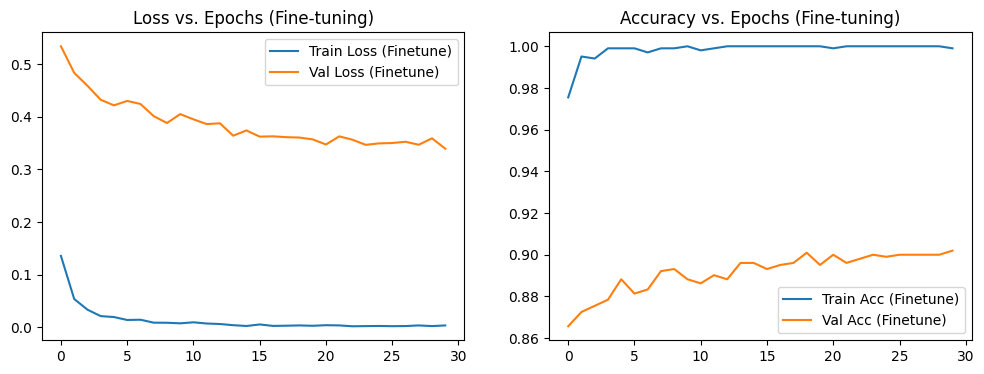

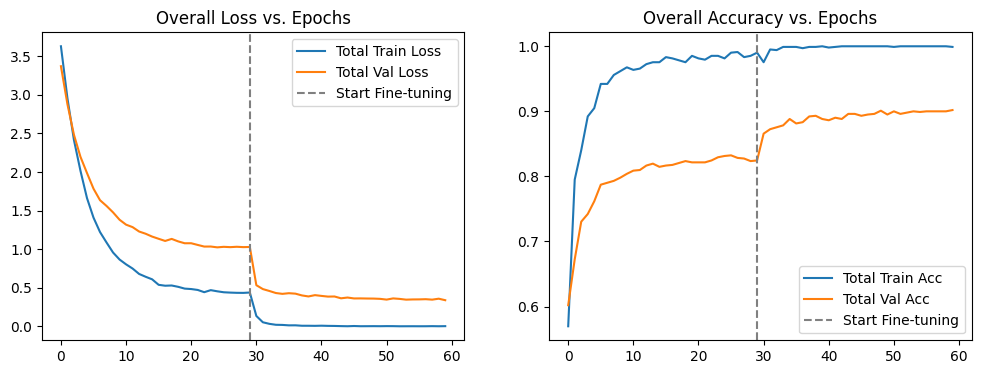

In [ ]:
print("\n--- Starting Phase 2: Fine-tuning the model ---")


# We'll unfreeze all layers here.
print("Unfreezing all model parameters for fine-tuning...")
for param in model_head_trained.parameters(): # Use the model that has the trained head
    param.requires_grad = True
print("All parameters unfrozen.")


FINETUNE_LR = LEARNING_RATE / 10

optimizer_finetune = optim.AdamW(
    model_head_trained.parameters(), # Now optimize all parameters
    lr=FINETUNE_LR,
    weight_decay=0.01 # Keep some weight decay
)
print(f"Optimizer for fine-tuning: AdamW with LR={FINETUNE_LR}")


scheduler_finetune = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_finetune,
    T_max=NUM_EPOCHS_FINETUNE,
    eta_min=FINETUNE_LR / 100 # e.g., go down to 1% of the fine-tuning LR
)


print(f"Learning rate scheduler for fine-tuning: CosineAnnealingLR with T_max={NUM_EPOCHS_FINETUNE}")



model_finetuned, history_finetune = train_model(
    model=model_head_trained, # Start with the model that has its head trained
    criterion=criterion,      # Same loss function
    optimizer=optimizer_finetune,
    scheduler=scheduler_finetune,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    num_epochs=NUM_EPOCHS_FINETUNE, # Use the number of epochs set for fine-tuning
    model_name_prefix="resnet50_flowers_finetuned" # New prefix for saved models
)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finetune['train_loss'], label='Train Loss (Finetune)')
plt.plot(history_finetune['val_loss'], label='Val Loss (Finetune)')
plt.legend()
plt.title('Loss vs. Epochs (Fine-tuning)')
plt.subplot(1, 2, 2)
plt.plot(history_finetune['train_acc'], label='Train Acc (Finetune)')
plt.plot(history_finetune['val_acc'], label='Val Acc (Finetune)')
plt.legend()
plt.title('Accuracy vs. Epochs (Fine-tuning)')
plt.show()

# Also, to see the overall learning curve:
total_train_loss = history_head['train_loss'] + history_finetune['train_loss']
total_val_loss = history_head['val_loss'] + history_finetune['val_loss']
total_train_acc = history_head['train_acc'] + history_finetune['train_acc']
total_val_acc = history_head['val_acc'] + history_finetune['val_acc']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(total_train_loss, label='Total Train Loss')
plt.plot(total_val_loss, label='Total Val Loss')
plt.axvline(x=NUM_EPOCHS_HEAD -1 , color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend()
plt.title('Overall Loss vs. Epochs')
plt.subplot(1, 2, 2)
plt.plot(total_train_acc, label='Total Train Acc')
plt.plot(total_val_acc, label='Total Val Acc')
plt.axvline(x=NUM_EPOCHS_HEAD-1, color='gray', linestyle='--', label='Start Fine-tuning')
plt.legend()
plt.title('Overall Accuracy vs. Epochs')
plt.show()

In [28]:


# --- Step 7: Evaluation on the Test Set ---
print("\n--- Starting Evaluation on the Test Set ---")



model_finetuned.eval()  # Set the model to evaluation mode

test_losses = AverageMeter()
test_accuracies = AverageMeter()
all_preds = []
all_labels = []

start_time_test = time.time()

progress_bar_test = tqdm(test_loader, desc="Testing", unit="batch")

with torch.no_grad():  # Ensuring no gradients are computed during testing
    for inputs, labels in progress_bar_test:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model_finetuned(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        acc = torch.sum(preds == labels.data).item() / labels.size(0)

        test_losses.update(loss.item(), inputs.size(0))
        test_accuracies.update(acc, inputs.size(0))

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar_test.set_postfix(loss=test_losses.avg, acc=test_accuracies.avg)

end_time_test = time.time()
test_duration = end_time_test - start_time_test

print("\n--- Test Set Evaluation Finished ---")
print(f"Test Loss: {test_losses.avg:.4f}")
print(f"Test Accuracy: {test_accuracies.avg:.4f} ({test_accuracies.sum*100/test_accuracies.count:.2f}%)") # Show percentage
print(f"Total test samples: {test_accuracies.count}")
print(f"Testing duration: {test_duration:.2f}s")


--- Starting Evaluation on the Test Set ---


Testing: 100%|██████████| 193/193 [01:37<00:00,  1.98batch/s, acc=0.898, loss=0.397]


--- Test Set Evaluation Finished ---
Test Loss: 0.3971
Test Accuracy: 0.8980 (89.80%)
Total test samples: 6149
Testing duration: 97.71s
